# Лабораторная работа 6.

### Cегментация изображений


In [ ]:
%reset
#%pip install scikit-image
#%pip install scikit-learn

In [167]:
import numpy as np
import cv2 as cv
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt

### Загрузим изображение и уменьшим его масштаб

In [168]:
image = cv.imread('./fruit.png')

resized0 = cv.resize(image, (int(image.shape[1]*0.3), int(image.shape[0]*0.3)), interpolation=cv.INTER_AREA)
resized = resized0[:,100:612 ]

image_hsv = cv.cvtColor(resized, cv.COLOR_RGB2HSV)
gray = cv.cvtColor(resized, cv.COLOR_BGR2GRAY)

Разрастание областей (region growing)

Определяем координаты начальных точек и порог похожести для цвета

In [169]:
# определяем координаты начальных точек
seeds = [(410, 276), (250, 275), (150, 256), (220,220)]
# координаты для графика
x = list(map(lambda x: x[1], seeds))
y = list(map(lambda x: x[0], seeds))
# порог похожести цвета региона
threshold = 25

Функция, реализующая алгоритм разрастания регионов:

In [170]:
def region_growingHSV(image, seed, threshold):
    # Create an empty binary mask to store the segmented region
    region_mask = np.zeros(image.shape[0:2], dtype=np.uint8)

    # Define the connectivity (4-connectivity in this case)
    # , (1, 1), (-1,-1), (1, -1), (-1, 1)
    connectivity = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    # Create a queue to store the pixels to be processed
    queue = []

    for i in seed:
        # Get the seed coordinates
        seed_x, seed_y = i
        queue.append((seed_x, seed_y))

        # Perform region growing
        while len(queue) > 0:
            x, y = queue.pop(0)

            # Check if the pixel is within the image boundaries
            if x < 0 or x >= image.shape[0] or y < 0 or y >= image.shape[1]:
                continue

            # Check if the pixel has already been visited
            if region_mask[x, y] != 0:
                continue

            # Calculate the similarity measure
            similarity = sum(abs(image[x, y, :] - image[seed_x, seed_y, :]))/3

            # Check if the pixel is similar to the seed pixel
            if similarity < threshold:
                region_mask[x, y] = 255  # Add the pixel to the region
                # Add the neighbors to the queue for further processing
                for dx, dy in connectivity:
                    queue.append((x + dx, y + dy))

    return region_mask

Находим сегментацию используя метод разрастания регионов и отображаем результат

[220 224 229]


C:\Users\User\AppData\Local\Temp\ipykernel_2992\682105106.py:29: RuntimeWarning: overflow encountered in scalar add
  similarity = sum(abs(image[x, y, :] - image[seed_x, seed_y, :]))/3


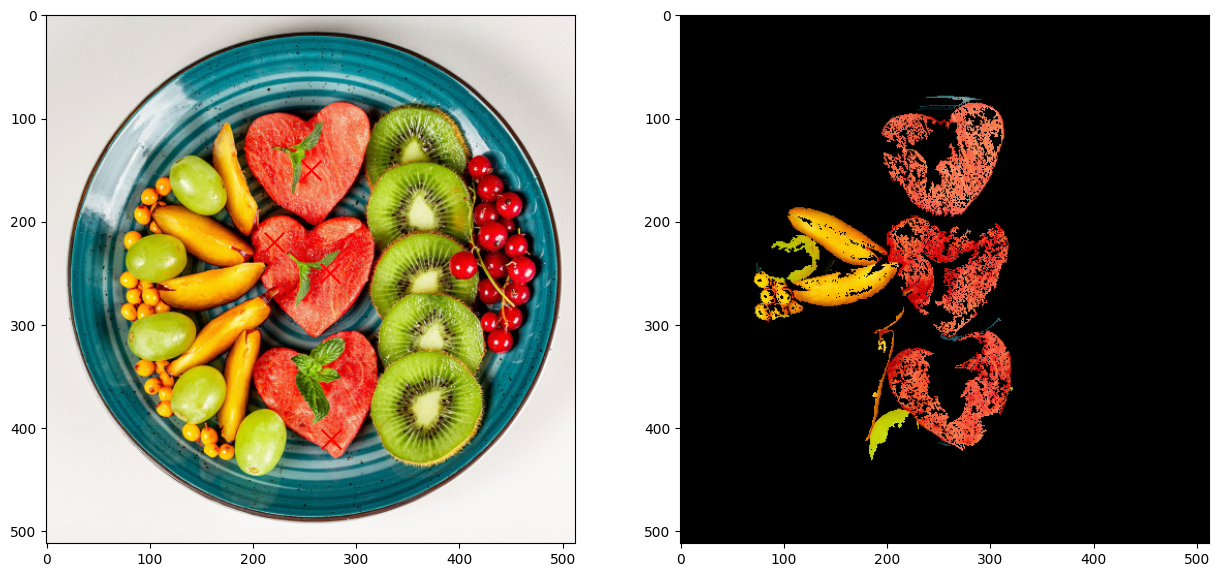

In [171]:
print(image[seeds[0]])
# находим сегментацию используя метод из segmentation_utils
segmented_region = region_growingHSV(image_hsv, seeds, threshold)
# накладываем маску - отображаем только участки попавшие в какой-либо сегмент
result = cv.bitwise_and(resized, resized, mask=segmented_region)
# отображаем полученное изображение
plt.figure(figsize=(15,20))
plt.subplot(1, 2, 1)
plt.scatter(x, y, marker="x", color="red", s=200)
plt.imshow(cv.cvtColor(resized, cv.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

Number of segments:  17
[[227 230 233]
 [113 105  10]
 [ 63 102 237]
 [ 66 203 190]
 [ 24 172 160]
 [ 11 181 245]
 [ 10  15  22]
 [ 18  23 220]
 [115 121  84]
 [ 20 106 103]
 [169 169 132]
 [ 72  78  58]
 [ 34  51  52]
 [114 209 222]
 [177 211 214]
 [  7  14  95]
 [ 13  47 153]]


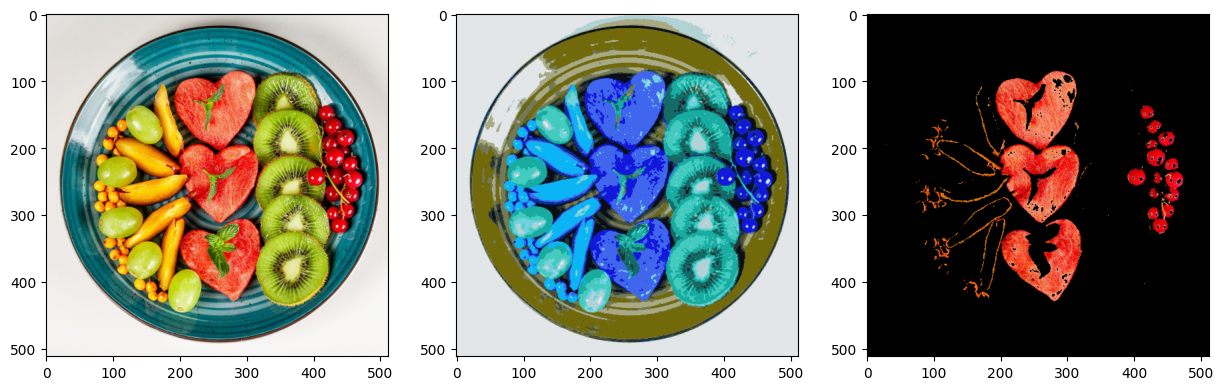

In [172]:
## Методы кластеризации. Сдвиг среднего (Mean shift)
# Сглаживаем чтобы уменьшить шум
blur_image = cv.medianBlur(resized, 3)
# Выстраиваем пиксели в один ряд и переводим в формат с правающей точкой
flat_image = np.float32(blur_image.reshape((-1,3)))

# Используем meanshift из библиотеки sklearn
bandwidth = estimate_bandwidth(flat_image, quantile=.03, n_samples=3000)
ms = MeanShift(bandwidth=bandwidth, max_iter=800, bin_seeding=True)
ms.fit(flat_image)
labeled = ms.labels_

# получим количество сегментов
segments = np.unique(labeled)
print('Number of segments: ', segments.shape[0])

# получим средний цвет сегмента
total = np.zeros((segments.shape[0], 3), dtype=float)
count = np.zeros(total.shape, dtype=float)
for i, label in enumerate(labeled):
    total[label] = total[label] + flat_image[i]
    count[label] += 1
avg = total/count
avg = np.uint8(avg)

print(avg)
# Для каждого пискеля проставим средний цвет его сегмента
mean_shift_image = avg[labeled].reshape((resized.shape))

# Маской скроем один из сегментов
#mask1 = mean_shift_image[:,:,0]
#mask1[mask1==17] = 0


segments_to_keep = [2,7]
# Создаем бинарную маску: 255 для всех пикселей, кроме скрываемого сегмента
mask = np.zeros(labeled.shape, dtype=np.uint8)
for segment_id in segments_to_keep:
    mask[labeled == segment_id] = 255

# Изменяем форму маски под исходное изображение
mask1 = mask.reshape(resized.shape[:2])

mean_shift_with_mask_image = cv.bitwise_and(resized, resized, mask=mask1)
# Построим изображение
plt.figure(figsize=(15,20))
plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(resized, cv.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.imshow(mean_shift_image, cmap='Set3')
plt.subplot(1, 3, 3)
plt.imshow(cv.cvtColor(mean_shift_with_mask_image, cv.COLOR_BGR2RGB))
plt.show()